<a href="https://colab.research.google.com/github/dirudiez/TFM_DiegoRudiez/blob/main/binario/FL/Binario_FL_inception_v3_BalanceoSklearn_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

https://notebooks.githubusercontent.com/view/ipynb?browser=chrome&color_mode=auto&commit=550a08945499aa9ff119547dc4aefbbeec0e5dbf&device=unknown&enc_url=68747470733a2f2f7261772e67697468756275736572636f6e74656e742e636f6d2f77616c6b776974686661737461692f77616c6b776974686661737461692e6769746875622e696f2f353530613038393435343939616139666631313935343764633461656662626565633065356462662f6e62732f30325f766973696f6e2e65787465726e616c2e74696d6d2e6970796e62&logged_in=false&nwo=walkwithfastai%2Fwalkwithfastai.github.io&path=nbs%2F02_vision.external.timm.ipynb&platform=android&repository_id=295613905&repository_type=Repository&version=98

En este cuaderno probaremos la arquitectura efficientnet_b3 para ver si obtenemos unos mejores resultados.

## Efficientnet_b3 con Balanceo Sklearn

In [1]:
!pip install fastai -Uq
!pip install timm

#Reiniciamos el entorno de ejecución automáticamente
import IPython
IPython.Application.instance().kernel.do_shutdown(True)

     |████████████████████████████████| 214 kB 29.5 MB/s 
     |████████████████████████████████| 61 kB 7.8 MB/s 
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 431 kB 18.8 MB/s 


{'restart': True, 'status': 'ok'}

In [1]:
!pip install wwf -q
# !pip install nbdev

In [2]:
from fastai.vision.all import *

import timm
from wwf.utils import *
from wwf.vision.timm import *

## Dataset

En este caso estamos usando el dataset que ha sido preprocesados mediante el método de recorte

In [3]:
!wget https://www.dropbox.com/s/o1eaoae59qgdo4i/Training_Set_Pre.zip?dl=0 --no-verbose -O train.zip
!wget https://www.dropbox.com/s/5od5cac9xhxlcwu/Test_Set_Pre.zip?dl=0 --no-verbose -O test.zip
!wget https://www.dropbox.com/s/gjz445xm4oddfus/Evaluation_Set_Pre.zip?dl=0 --no-verbose -O val.zip

2022-07-01 09:39:24 URL:https://uc7501892447b11747c5541d784a.dl.dropboxusercontent.com/cd/0/inline2/BoMze8PJ9FfZpyaw6EcGlI1NlAGL_EMZDa5dd1YAtm3r4g9jzpnLC27aJ8e1nTApUaqGOr5EkMFQkHQodRpW2mBDELKuUQDKUgdULbCmPJQvBOeg1f-DhX_17FZbOmjIHxiafq6SUwGTYOO5DMXqOgL-2abbHyJOniDZvMv-r_lsTxJAzcN8NdJbuzBsqPryCz8PZYRJwjgFHh1xe1hzxt5o9gvSZPlNdkavTGkV2jKTNrAK1Zq0dX-nKJ2Sr_pzbYt67FNrQj4yZCmm3KrpMoYmDDOFudhvD7gQJQpNN0CL5wAiKMov2F6YUzduRYCJuXO6WGLlAnQPj-1CskECvYL204_CMmBEI2Q2dob8ov2pwODYFXrCcU9nwfT9YL3pDEIgvAbGbz5RZMkHvvIXhq7jCa-NbS9W7xaXJV7j0jqirw/file [138777773/138777773] -> "train.zip" [1]
2022-07-01 09:39:26 URL:https://ucb75e77be3930607f831f68eb51.dl.dropboxusercontent.com/cd/0/inline2/BoO8bLN9oWKFm5JZLktbBg00Tu_JV5F74ACCC7WKT5yxk1YSnHZZWPq2P5aAzO3ystlrK-y5pFW3SfedQHM8uNGJvQfS-tsOWqqLbLQzcuJDZBGn4WkhuOpsYJhUwl7kQW1Z-w9_hS_TSXyv8clmWIxPG0mQgMPzZDX3V48_JKfTd28R9VqOhjxJPNIh8HUNRa9iaPRu4sfBPOo2Fc3kj99Zggaohz5ZQXOHfruRq6k7Qs_K3YItolkJKzU_GCOFl26KYpApjPTCZSMJFLSYIP9chPg7uBLkkfs_2Zz6zCy2et9SyifSWRINkHUNsTM_mRf

In [4]:
# !rm -rvf Training_Set_Pre
!unzip -qq train.zip #-qq no verbose
!unzip -qq test.zip
!unzip -qq val.zip

In [5]:
#Método para crear estructura de directorios
def crearEstructura(nombreDataset, clases):
  !mkdir "$nombreDataset"
  !mkdir "$nombreDataset"/test
  !mkdir "$nombreDataset"/train
  !mkdir "$nombreDataset"/val
  for x in clases:
    !mkdir "$nombreDataset"/train/"$x"
    !mkdir "$nombreDataset"/test/"$x"
    !mkdir "$nombreDataset"/val/"$x"

In [6]:
crearEstructura('dataset', ['normal', 'enfermedad'])

In [7]:
trainPath = Path('Training_Set_Pre/')
testPath  = Path('Test_Set_Pre/')
valPath  =  Path('Evaluation_Set_Pre/')

In [8]:
df_train = pd.read_csv(str(trainPath) + '/train.csv')
df_test = pd.read_csv(str(testPath) + '/test.csv')
df_val = pd.read_csv(str(valPath) + '/val.csv')

#### Mover imágenes:

In [9]:
import shutil
import uuid

def moverImg(df, pathO, pathD):
  for id, enf in zip(df['ID'], df['Disease_Risk']):
    if(int(enf)==0):
        shutil.copy(pathO + '/' + str(id) + '.png', pathD + '/normal/' + str(uuid.uuid1()) + '.png')
    else:
        shutil.copy(pathO + str(id) + '.png', pathD + '/enfermedad/' + str(uuid.uuid1()) + '.png')

In [10]:
path = Path('dataset')

## Balanceo

In [11]:
from sklearn.utils import resample

In [12]:
df_majority = df_train[df_train.Disease_Risk==1] #mayoria de instacias con enfermedad respecto a sin ella.
df_minority = df_train[df_train.Disease_Risk==0]

In [13]:
# Aumentar la muestra de la clase minoritaria
# Aumentar la muestra de la clase minoritaria
df_minority_upsampled = resample(df_minority,
                                 replace=True,     # muestra con remplazamiento
                                 n_samples=960,    # número de muestras de la clase mayoritaria
                                 random_state=42) # semilla para que los resultados sean reproducibles

# Disminuir la clase mayoritaria
df_majority_downsampled = resample(df_majority, 
                                 replace=False,    # muestra sin remplazamiento
                                 n_samples=960,     # número de muestras de la clase minoritaria
                                 random_state=42) # semilla para que los datos sean reproducibles
                               
# Combinar el nuevo grupo con el grupo original mayoritario
df_train = pd.concat([df_majority_downsampled, df_minority_upsampled])
df_train = df_train.reset_index(drop=True)

# Mostrar el número de instancias en cada clase
df_train.Disease_Risk.value_counts()

1    960
0    960
Name: Disease_Risk, dtype: int64

In [14]:
len(df_minority_upsampled.ID.unique())

359

**Una vez que tenemos el dataframe balanceado comenzamos a copiar las imágenes a las carpetas que corresponda.**

In [15]:
moverImg(df_train, str(trainPath) + '/Training/', str(path)  + '/train')
moverImg(df_test, str(testPath) + '/Test/', str(path)  + '/test')
moverImg(df_val, str(valPath) + '/Validation/', str(path)  + '/val')

## Cargando el dataset

In [16]:
db = DataBlock(blocks = (ImageBlock, CategoryBlock),
                 get_items=get_image_files, 
                 splitter=GrandparentSplitter(train_name='train', valid_name='val'),
                 get_y=parent_label,
                 item_tfms = Resize(256),
                 batch_tfms=aug_transforms(size=128,min_scale=0.75))

In [17]:
dls = db.dataloaders(path,bs=128)

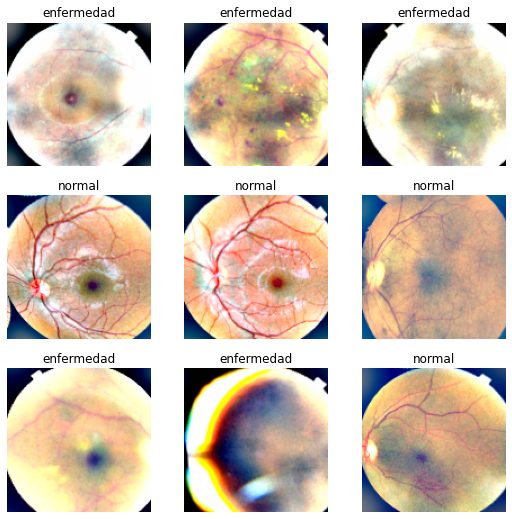

In [18]:
dls.show_batch()

In [19]:
callbacks = [
    ShowGraphCallback(),
    EarlyStoppingCallback(patience=20),
    SaveModelCallback()
]

In [21]:
metrics = [ accuracy, Precision(), Recall(), F1Score() ]
learn = timm_learner(dls, 'inception_v3', metrics=metrics, loss_func=FocalLoss(), cbs=callbacks).to_fp16()

Downloading: "https://download.pytorch.org/models/inception_v3_google-1a9a5a14.pth" to /root/.cache/torch/hub/checkpoints/inception_v3_google-1a9a5a14.pth


SuggestedLRs(minimum=0.004786301031708717, steep=1.0964781722577754e-06, valley=0.0010000000474974513, slide=0.010964781977236271)

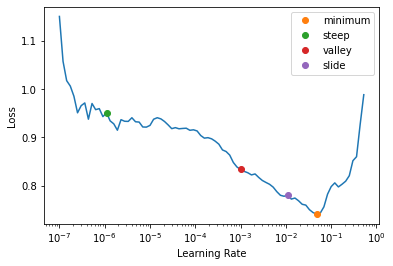

In [22]:
learn.lr_find(suggest_funcs=(minimum, steep, valley, slide))

## Entrenamos el modelo

epoch,train_loss,valid_loss,accuracy,precision_score,recall_score,f1_score,time
0,0.787299,0.452142,0.665625,0.368421,0.835821,0.511416,00:09


Better model found at epoch 0 with valid_loss value: 0.4521421492099762.


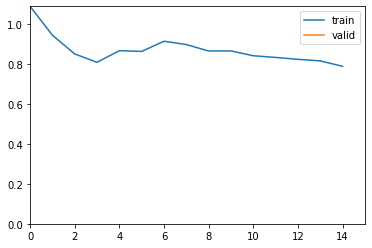

epoch,train_loss,valid_loss,accuracy,precision_score,recall_score,f1_score,time
0,0.725821,0.266209,0.734375,0.420354,0.708955,0.527778,00:09
1,0.682247,0.316141,0.706250,0.401460,0.820896,0.539216,00:09
2,0.621287,0.195201,0.804688,0.524590,0.716418,0.605678,00:10
3,0.588493,0.202254,0.764063,0.460829,0.746269,0.569801,00:10
4,0.566220,0.259360,0.718750,0.410156,0.783582,0.538462,00:10
5,0.555426,0.287882,0.720312,0.414449,0.813433,0.549118,00:11
6,0.540093,0.258820,0.698438,0.398625,0.865672,0.545882,00:09
7,0.529423,0.158242,0.781250,0.485437,0.746269,0.588235,00:09
8,0.509542,0.226437,0.725000,0.421053,0.835821,0.560000,00:09
9,0.503685,0.196905,0.737500,0.434109,0.835821,0.571429,00:09


Better model found at epoch 0 with valid_loss value: 0.2662094831466675.


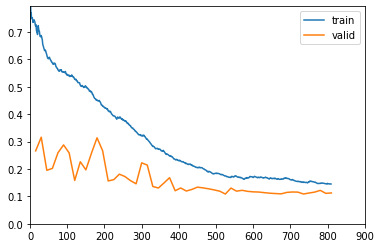

Better model found at epoch 2 with valid_loss value: 0.19520094990730286.
Better model found at epoch 7 with valid_loss value: 0.15824170410633087.
Better model found at epoch 13 with valid_loss value: 0.1564330905675888.
Better model found at epoch 18 with valid_loss value: 0.1459917426109314.
Better model found at epoch 21 with valid_loss value: 0.13615237176418304.
Better model found at epoch 22 with valid_loss value: 0.13068340718746185.
Better model found at epoch 25 with valid_loss value: 0.12065140902996063.
Better model found at epoch 27 with valid_loss value: 0.11964257806539536.
Better model found at epoch 33 with valid_loss value: 0.11899157613515854.
Better model found at epoch 34 with valid_loss value: 0.10866625607013702.
No improvement since epoch 34: early stopping
CPU times: user 3min 37s, sys: 18.6 s, total: 3min 56s
Wall time: 9min 32s


In [23]:
%%time
learn.fine_tune(60,base_lr=1e-3)

## Evaluando el Modelo

In [24]:
dbTest = DataBlock(blocks = (ImageBlock, CategoryBlock),
                 get_items=get_image_files, 
                 splitter=GrandparentSplitter(valid_name='test'),
                 get_y=parent_label,
                 item_tfms = Resize(256),
                 batch_tfms=aug_transforms(size=128,min_scale=0.75))
dlsTest = dbTest.dataloaders(path,bs=128)

In [25]:
learn.dls = dlsTest

In [26]:
learn.validate()

Better model found at epoch 0 with valid_loss value: 0.7828124761581421.


(#5) [0.11467720568180084,0.7828124761581421,0.4897959183673469,0.8955223880597015,0.633245382585752]

Exportamos el modelo:

In [27]:
learn.to_fp32()
learn.export('Binario_FL_inception_v3_BalanceoSklearn.pkl')

## Interpretación del modelo


/usr/local/lib/python3.7/dist-packages/fastai/vision/learner.py:275: UserWarning: `cnn_learner` has been renamed to `vision_learner` -- please update your code
  warn("`cnn_learner` has been renamed to `vision_learner` -- please update your code")
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth


  0%|          | 0.00/44.7M [00:00<?, ?B/s]

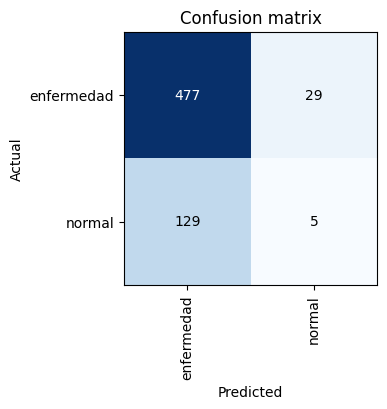

In [28]:
learn_inf = load_learner('Binario_FL_inception_v3_BalanceoSklearn.pkl')
learnInterp = cnn_learner(dls,resnet18).to_fp16()
learnInterp.model = learn_inf.model
interp = ClassificationInterpretation.from_learner(learnInterp)
interp.plot_confusion_matrix(figsize=(4,4),dpi=100)

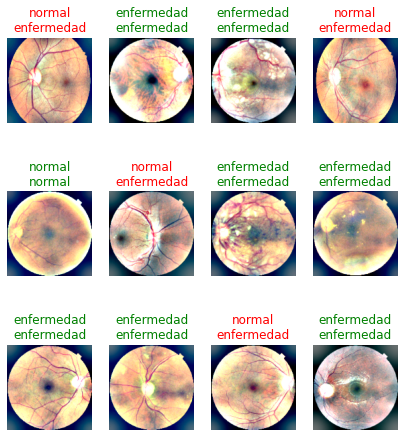

In [29]:
learnInterp.show_results(max_n=12, figsize=(7,8))